In [10]:
# %%time

# from google.colab import files

# uploaded = files.upload()

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import StratifiedKFold

!pip install catboost
from catboost import CatBoostClassifier as cb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 64.8MB 65kB/s 


In [12]:
train = pd.read_csv('/content/Train_aBjfeNk.csv')
test = pd.read_csv('/content/Test_LqhgPWU.csv')

print('Train shape:{},{}'.format(train.shape[0], train.shape[1]))
print('Test shape:{},{}'.format(test.shape[0], test.shape[1]))

Train shape:8068,11
Test shape:2627,10


In [13]:
train.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [14]:
test.isnull().sum()

ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession          38
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1               32
dtype: int64

In [15]:
train['Age_Bins'] = pd.cut(train['Age'], bins=np.linspace(10, 90, 9)).astype('str')
test['Age_Bins'] = pd.cut(test['Age'], bins=np.linspace(10, 90, 9)).astype('str')

neat_age_binning = {
      '(10.0, 20.0]' : 'age_10'
    , '(20.0, 30.0]' : 'age_20'
    , '(30.0, 40.0]' : 'age_30'
    , '(40.0, 50.0]' : 'age_40'
    , '(50.0, 60.0]' : 'age_50'
    , '(60.0, 70.0]' : 'age_60'
    , '(70.0, 80.0]' : 'age_70'
    , '(80.0, 90.0]' : 'age_80'
}

train['Age_Bins'] = train['Age_Bins'].map(neat_age_binning)
test['Age_Bins'] = test['Age_Bins'].map(neat_age_binning)

In [16]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_Bins
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D,age_20
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A,age_30
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B,age_60
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B,age_60
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A,age_30


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
 11  Age_Bins         8068 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 756.5+ KB


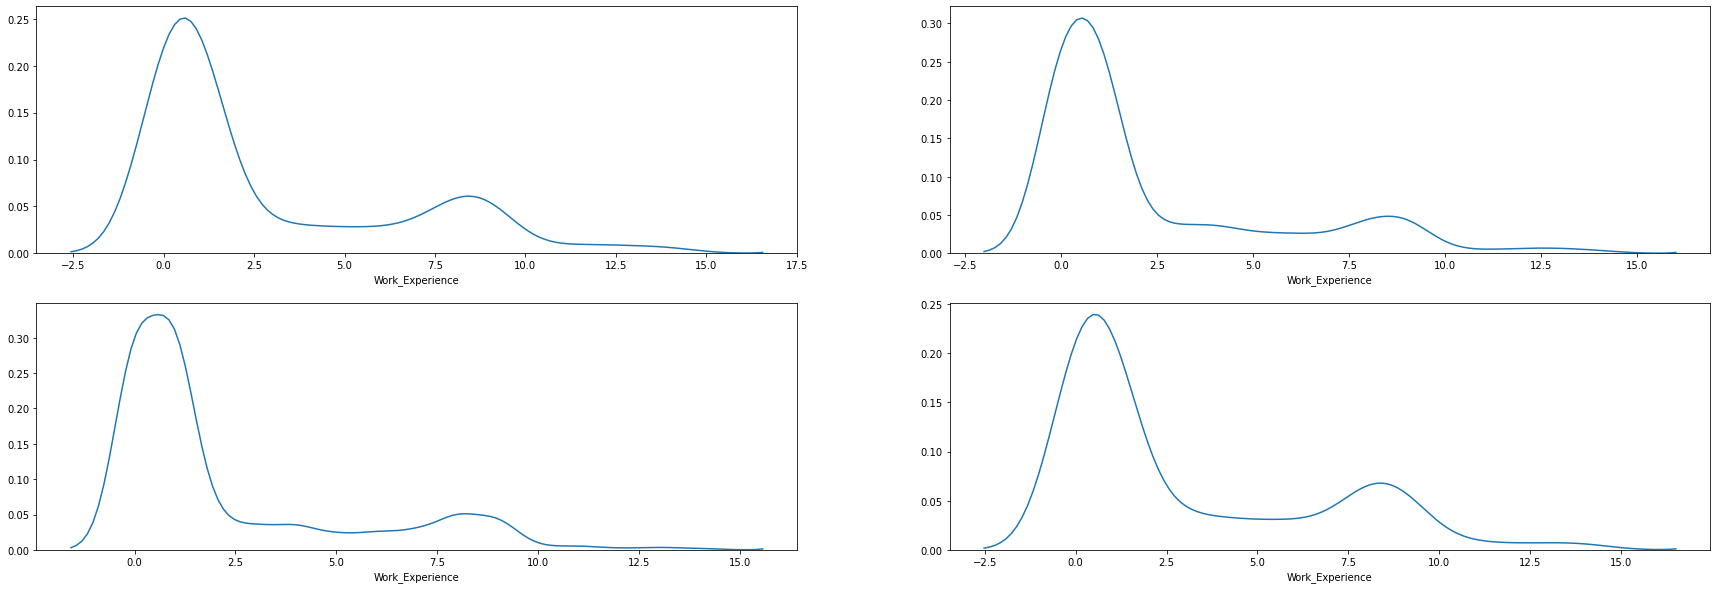

In [18]:
seg = ['A', 'B', 'C', 'D']

fig, ax = plt.subplots(2, 2, figsize=(30,10))

for s in range(0, len(seg)):
  tmp = train[train['Segmentation']==seg[s]]
  bins = np.linspace(0, 15, 1)
  sns.distplot(tmp['Work_Experience'], bins=bins, ax=ax[int(s/2)][s%2])


## Label Encoding

#### Use label encoding to encode categorical data. And custom encoding where hierarchy is to be preserved.

In [19]:
cat_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession',
                'Spending_Score', 'Var_1', 'Segmentation', 'Age_Bins']

le_gender = LabelEncoder()
le_married = LabelEncoder()
le_graduated = LabelEncoder()
le_profession = LabelEncoder()
le_segment = LabelEncoder()
le_source = LabelEncoder()

train['source'] = 'train'
test['source'] = 'test'

unified = pd.concat([train, test], axis=0)
unified.fillna('None', inplace=True)

unified['Gender'] = le_gender.fit_transform(unified['Gender'])
unified['Ever_Married'] = le_married.fit_transform(unified['Ever_Married'])
unified['Graduated'] = le_graduated.fit_transform(unified['Graduated'])
unified['Profession'] = le_profession.fit_transform(unified['Profession'])
unified['Segmentation'] = le_segment.fit_transform(unified['Segmentation'])
unified['source'] = le_source.fit_transform(unified['source'])

spending = {
      'Low' : 1
    , 'Average' : 2
    , 'High' : 3
}

var1 = {
      'Cat_1' : 1
    , 'Cat_2' : 2
    , 'Cat_3' : 3
    , 'Cat_4' : 4
    , 'Cat_5' : 5
    , 'Cat_6' : 6
    , 'Cat_7' : 7
    , 'None'  : 0

}

agebin = {
      'age_10' : 1
    , 'age_20' : 2
    , 'age_30' : 3
    , 'age_40' : 4
    , 'age_50' : 5
    , 'age_60' : 6
    , 'age_70' : 7
    , 'age_80' : 8
}

unified['Spending_Score'] = unified['Spending_Score'].map(spending)
unified['Var_1'] = unified['Var_1'].map(var1)
unified['Age_Bins'] = unified['Age_Bins'].map(agebin)
unified.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_Bins,source
0,462809,1,0,22,0,5,1,1,4,4,3,2,1
1,462643,0,2,38,2,2,None,2,3,4,0,3,1
2,466315,0,2,67,2,2,1,1,1,6,1,6,1
3,461735,1,2,67,2,7,0,3,2,6,1,6,1
4,462669,0,2,40,2,3,None,3,6,6,0,3,1


In [20]:
# Obtain encodings for missing values from each encoded column

def obtain_miss_val_encoding(encoding_fn):
  tmp = dict(zip(encoding_fn.classes_, 
                 encoding_fn.transform(encoding_fn.classes_)))
  return tmp


mapping_gender = obtain_miss_val_encoding(le_gender)
mapping_married = obtain_miss_val_encoding(le_married)
mapping_graduated = obtain_miss_val_encoding(le_graduated)
mapping_profession = obtain_miss_val_encoding(le_profession)
mapping_segment = obtain_miss_val_encoding(le_segment)
mapping_source = obtain_miss_val_encoding(le_source)

In [21]:
mapping_segment

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'None': 4}

In [22]:
# Recode the missing values from encoded values in each column

unified.loc[unified['Ever_Married']==1, 'Ever_Married'] = 'None'
unified.loc[unified['Graduated']==1, 'Graduated'] = 'None'
unified.loc[unified['Profession']==9, 'Profession'] = 'None'
unified.loc[unified['Var_1']==0, 'Var_1'] = 'None'

unified.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_Bins,source
0,462809,1,0,22,0,5,1,1,4,4,3,2,1
1,462643,0,2,38,2,2,None,2,3,4,0,3,1
2,466315,0,2,67,2,2,1,1,1,6,1,6,1
3,461735,1,2,67,2,7,0,3,2,6,1,6,1
4,462669,0,2,40,2,3,None,3,6,6,0,3,1


In [23]:
unified.isnull().sum()

ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
Segmentation       0
Age_Bins           0
source             0
dtype: int64

## Impute missing values

In [24]:
unified = unified.replace('None', 99)
imputer = KNNImputer(missing_values=99, n_neighbors=5)

unified_imputed = unified.copy()
id = unified_imputed['ID'].reset_index(drop=True)
unified_imputed.drop(['ID'], axis=1, inplace=True)

cols = unified_imputed.columns
unified_imputed = pd.DataFrame(imputer.fit_transform(unified_imputed), columns=cols)
unified_imputed.reset_index(drop=True, inplace=True)
unified_imputed = pd.concat([id, unified_imputed], axis=1)

cols_with_miss_values = ['Ever_Married', 'Graduated', 'Profession',
                         'Work_Experience', 'Family_Size', 'Var_1']

for c in cols_with_miss_values:
  unified_imputed[c] = unified_imputed[c].apply(lambda x: round(x,0))

In [25]:
def recode_cat_var(df, encoding_fn, col):
  reverse_encoding_fn = {v:k for k, v in encoding_fn.items()}

  df[col] = df[col].map(reverse_encoding_fn)
  return df

rev_enc_map = {
        'Gender' : mapping_gender
      , 'Graduated' : mapping_graduated
      , 'Ever_Married' : mapping_married
      , 'Profession' : mapping_profession
      , 'Spending_Score' : spending
      , 'Var_1' : var1
      , 'Segmentation' : mapping_segment
      , 'source' : mapping_source
      , 'Age_Bins' : agebin
}

for k, v in rev_enc_map.items():
  unified_final = recode_cat_var(unified_imputed, v, k)

unified_final.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_Bins,source
0,462809,Male,No,22.0,No,Healthcare,1.0,Low,4.0,Cat_4,D,age_20,train
1,462643,Female,Yes,38.0,Yes,Engineer,2.0,Average,3.0,Cat_4,A,age_30,train
2,466315,Female,Yes,67.0,Yes,Engineer,1.0,Low,1.0,Cat_6,B,age_60,train
3,461735,Male,Yes,67.0,Yes,Lawyer,0.0,High,2.0,Cat_6,B,age_60,train
4,462669,Female,Yes,40.0,Yes,Entertainment,5.0,High,6.0,Cat_6,A,age_30,train


In [26]:
unified_imputed.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_Bins,source
0,462809,Male,No,22.0,No,Healthcare,1.0,Low,4.0,Cat_4,D,age_20,train
1,462643,Female,Yes,38.0,Yes,Engineer,2.0,Average,3.0,Cat_4,A,age_30,train
2,466315,Female,Yes,67.0,Yes,Engineer,1.0,Low,1.0,Cat_6,B,age_60,train
3,461735,Male,Yes,67.0,Yes,Lawyer,0.0,High,2.0,Cat_6,B,age_60,train
4,462669,Female,Yes,40.0,Yes,Entertainment,5.0,High,6.0,Cat_6,A,age_30,train


In [27]:
# # Using standard scaler

# scaler = StandardScaler()

# cols = unified_imputed.columns

# unified_imputed = pd.DataFrame(scaler.fit_transform(unified_imputed), columns=cols)
# unified_imputed.head()

## Model building

In [28]:
unified_final.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,Age_Bins,source
0,462809,Male,No,22.0,No,Healthcare,1.0,Low,4.0,Cat_4,D,age_20,train
1,462643,Female,Yes,38.0,Yes,Engineer,2.0,Average,3.0,Cat_4,A,age_30,train
2,466315,Female,Yes,67.0,Yes,Engineer,1.0,Low,1.0,Cat_6,B,age_60,train
3,461735,Male,Yes,67.0,Yes,Lawyer,0.0,High,2.0,Cat_6,B,age_60,train
4,462669,Female,Yes,40.0,Yes,Entertainment,5.0,High,6.0,Cat_6,A,age_30,train


In [29]:
# One-Hot Encoding Train and Test

encode_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession',
                'Spending_Score', 'Var_1', 'Age_Bins']
unified_final_dummies = pd.DataFrame()

unified_final_dummies = pd.get_dummies(unified_final[encode_cols],
                                       prefix=encode_cols)

miss_cols = ['ID', 'Work_Experience', 'Family_Size',
             'Segmentation', 'source']

unified_final_dummies.reset_index(drop=True, inplace=True)
unified_final.reset_index(drop=True, inplace=True)

unified_final_dummies = pd.concat([unified_final[miss_cols],
                                   unified_final_dummies], axis=1)

unified_final_dummies.head()

,ID,Work_Experience,Family_Size,Segmentation,source,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_None,Ever_Married_Yes,Graduated_No,Graduated_None,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Age_Bins_age_10,Age_Bins_age_20,Age_Bins_age_30,Age_Bins_age_40,Age_Bins_age_50,Age_Bins_age_60,Age_Bins_age_70,Age_Bins_age_80
0,462809,1.0,4.0,D,train,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,462643,2.0,3.0,A,train,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,466315,1.0,1.0,B,train,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,461735,0.0,2.0,B,train,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,462669,5.0,6.0,A,train,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


In [30]:
train = unified_final_dummies[unified_final_dummies['source']=='train']
test = unified_final_dummies[unified_final_dummies['source']=='test']

train.drop(['source'], inplace=True, axis=1)
test.drop(['source', 'Segmentation'], inplace=True, axis=1)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [31]:
skf = StratifiedKFold(n_splits=5, random_state=55)

X = train.copy()
y = X[['Segmentation']]
X.drop(['Segmentation'], inplace=True, axis=1)
X.fillna('None', inplace=True)

cat_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession',
                'Spending_Score', 'Var_1']

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [32]:
X.head()

,ID,Work_Experience,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_None,Ever_Married_Yes,Graduated_No,Graduated_None,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Age_Bins_age_10,Age_Bins_age_20,Age_Bins_age_30,Age_Bins_age_40,Age_Bins_age_50,Age_Bins_age_60,Age_Bins_age_70,Age_Bins_age_80
0,462809,1.0,4.0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
1,462643,2.0,3.0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,466315,1.0,1.0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,461735,0.0,2.0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,462669,5.0,6.0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


********************
Iteration#: 1
[0]	validation_0-merror:0.501239
Will train until validation_0-merror hasn't improved in 200 rounds.
[50]	validation_0-merror:0.449195
[100]	validation_0-merror:0.448575
[150]	validation_0-merror:0.449195
[200]	validation_0-merror:0.45601
[250]	validation_0-merror:0.448575
[300]	validation_0-merror:0.447955
[350]	validation_0-merror:0.449814
[400]	validation_0-merror:0.45539
[450]	validation_0-merror:0.461586
Stopping. Best iteration:
[268]	validation_0-merror:0.445477

********************
Iteration#: 2
[0]	validation_0-merror:0.504957
Will train until validation_0-merror hasn't improved in 200 rounds.
[50]	validation_0-merror:0.481413
[100]	validation_0-merror:0.466543
[150]	validation_0-merror:0.474597
[200]	validation_0-merror:0.473358
[250]	validation_0-merror:0.475836
[300]	validation_0-merror:0.481413
Stopping. Best iteration:
[102]	validation_0-merror:0.464684

********************
Iteration#: 3
[0]	validation_0-merror:0.513631
Will train unti

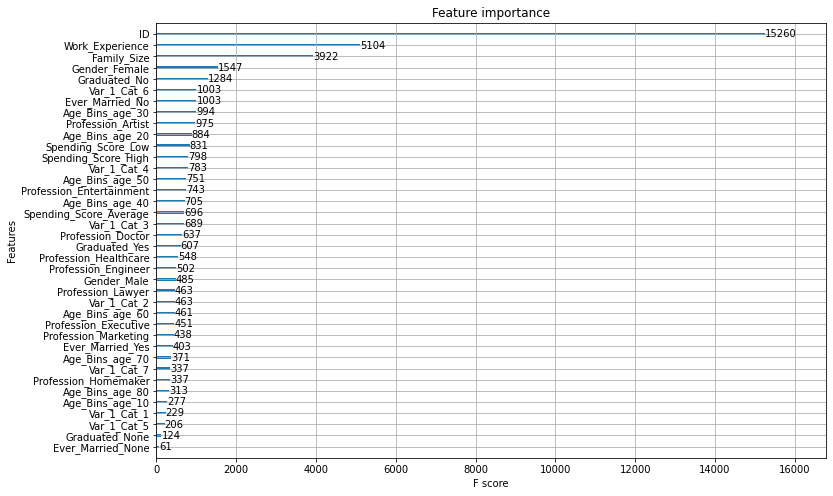

In [33]:
# XGBoost

pred_X = pd.DataFrame()
pred_y = pd.DataFrame()

for idx, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
  print('*'*20)
  print('Iteration#: {}'.format(idx+1))

  xgb_params = {
        'booster' : 'gbtree'
      , 'learning_rate' : 0.1
      , 'metric' : 'merror'
      , 'max_depth' : 6
      , 'colsample_bytree' : 0.7
      , 'objective' : 'multi:softmax'
      , 'seed' : 55
      , 'num_class' : 4
      , 'n_estimators' : 1000
  }

  X_tr, X_val, y_tr, y_val = X.iloc[tr_idx], X.iloc[val_idx], \
                              y.iloc[tr_idx], y.iloc[val_idx]

  clf = XGBClassifier(**xgb_params)
  model = clf.fit(X=X_tr, y=y_tr, eval_set=[(X_val, y_val)], \
                  early_stopping_rounds=200, verbose=50)
  
  pred_X = pd.concat([pred_X, X_val], axis=0)
  pred_y = pd.concat([pred_y, y_val], axis=0)

fig, ax = plt.subplots(figsize=(12,8))
plot_importance(model, ax=ax)

In [34]:
debug_preds = pd.DataFrame()
debug_preds = pd.concat([pred_X, pred_y], axis=1)
debug_preds.columns.values[-1] = 'Actual'

val_preds = pd.DataFrame(model.predict(pred_X))
debug_preds = pd.concat([debug_preds, val_preds], axis=1)
debug_preds.columns.values[-1] = 'Predicted'
debug_preds.head()

,ID,Work_Experience,Family_Size,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_None,Ever_Married_Yes,Graduated_No,Graduated_None,Graduated_Yes,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_1,Var_1_Cat_2,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_5,Var_1_Cat_6,Var_1_Cat_7,Age_Bins_age_10,Age_Bins_age_20,Age_Bins_age_30,Age_Bins_age_40,Age_Bins_age_50,Age_Bins_age_60,Age_Bins_age_70,Age_Bins_age_80,Actual,Predicted
0,462809,1.0,4.0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,D,D
1,462643,2.0,3.0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,A,D
2,466315,1.0,1.0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,B,B
3,461735,0.0,2.0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,B,C
4,462669,5.0,6.0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,A,A


In [35]:
accuracy_score(debug_preds['Actual'], debug_preds['Predicted'])
# 0.616757560733763

0.6734010907288052

In [36]:
test1 = test.copy()
test1.fillna('None', inplace=True)
preds = pd.DataFrame(model.predict(test1), columns=['Segmentation'])

ids = test1['ID'].reset_index(drop=True)
preds.reset_index(drop=True, inplace=True)
preds = pd.concat([ids, preds], axis=1)
preds.to_csv('xgboost_08012020.csv', index=False)

preds.head()

,ID,Segmentation
0,458989,B
1,458994,C
2,458996,D
3,459000,C
4,459001,D


In [37]:
# Catboost preparation

# train = unified_final[unified_final['source']=='train']
# test = unified_final[unified_final['source']=='test']

# train.drop(['source'], inplace=True, axis=1)
# test.drop(['source', 'Segmentation'], inplace=True, axis=1)

In [38]:
# skf = StratifiedKFold(n_splits=5, random_state=55)

# X = train.copy()
# y = X[['Segmentation']]
# X.drop(['Segmentation'], inplace=True, axis=1)
# X.fillna('None', inplace=True)

# cat_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession',
#                 'Spending_Score', 'Var_1']

In [39]:
# # Catboost

# pred_X = pd.DataFrame()
# pred_y = pd.DataFrame()
# feature_importance = pd.DataFrame()

# for idx, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
#   print('*'*20)
#   print('Iteration#: {}'.format(idx+1))

#   cat_params = {
#         'iterations' : 1000
#       , 'learning_rate' : 0.1
#       , 'depth' : 6
#       , 'eval_metric' : 'Accuracy'
#       , 'cat_features' : cat_features
#       , 'early_stopping_rounds' : 200
#   }
#   model = cb(**cat_params)

#   X_tr, y_tr, X_val, y_val = X.iloc[tr_idx], y.iloc[tr_idx], \
#                               X.iloc[val_idx], y.iloc[val_idx]

#   model.fit(X=X_tr, y=y_tr, eval_set=[(X_val, y_val)], verbose=50)

#   pred_X = pd.concat([pred_X, X_val], axis=0)
#   pred_y = pd.concat([pred_y, y_val], axis=0)

#   tmp_fi = pd.DataFrame()
#   tmp_fi['features'] = X_val.columns
#   tmp_fi['importance'] = cb.get_feature_importance(model)

#   feature_importance = pd.concat([feature_importance, tmp_fi], axis=0)

# feature_importance = feature_importance.groupby(['features'])['importance'].\
#                     mean().reset_index().\
#                     sort_values(by=['importance'], ascending=False)

# feature_importance

In [40]:
# debug_preds = pd.DataFrame()
# debug_preds = pd.concat([pred_X, pred_y], axis=1)
# debug_preds.columns.values[-1] = 'Actual'

# val_preds = pd.DataFrame(model.predict(pred_X))
# debug_preds = pd.concat([debug_preds, val_preds], axis=1)
# debug_preds.columns.values[-1] = 'Predicted'
# debug_preds.head()

In [41]:
# accuracy_score(debug_preds['Actual'], debug_preds['Predicted'])
# # 0.5767228557263262

In [42]:
# test1 = test.copy()
# test1.fillna('None', inplace=True)
# preds = pd.DataFrame(model.predict(test1), columns=['Segmentation'])

# ids = test1['ID'].reset_index(drop=True)
# preds.reset_index(drop=True, inplace=True)
# preds = pd.concat([ids, preds], axis=1)
# preds.to_csv('Imputed_catboost_08012020.csv', index=False)

# preds.head()

In [43]:
# KNN Preparation

# train = unified_imputed.iloc[:8068, :]
# test = unified_imputed.iloc[8068:, :]

# train.drop(['source'], inplace=True, axis=1)
# test.drop(['source', 'Segmentation'], inplace=True, axis=1)

# X = train.copy()
# y = X[['Segmentation']]
# X.drop(['Segmentation'], inplace=True, axis=1)

In [44]:
# skf = StratifiedKFold(n_splits=5, random_state=55)

# X = train.copy()
# y = X[['Segmentation']]
# X.drop(['Segmentation'], inplace=True, axis=1)
# X.fillna('None', inplace=True)

# cat_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession',
#                 'Spending_Score', 'Var_1']

In [45]:
# # KNN Classifier

# classifier = KNeighborsClassifier(n_neighbors=5)
# classifier.fit(X, y)

In [46]:
# debug_preds = pd.DataFrame()
# debug_preds = pd.concat([X, y], axis=1)
# debug_preds.columns.values[-1] = 'Actual'

# val_preds = pd.DataFrame(classifier.predict(X))
# debug_preds = pd.concat([debug_preds, val_preds], axis=1)
# debug_preds.columns.values[-1] = 'Predicted'
# debug_preds.head()

In [47]:
# accuracy_score(debug_preds['Actual'], debug_preds['Predicted'])
# # 0.616757560733763

In [48]:
# test1 = test.copy()
# mapping_segment_1 = {v:k for k,v in mapping_segment.items()}
# preds = pd.DataFrame(classifier.predict(test1), columns=['Segmentation'])
# preds['Segmentation'] = preds['Segmentation'].map(mapping_segment_1)

# ids = test1['ID'].reset_index(drop=True)
# preds.reset_index(drop=True, inplace=True)
# preds = pd.concat([ids, preds], axis=1)
# preds.to_csv('knn_08022020.csv', index=False)

# preds.head()